In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from keras.models import load_model

In [2]:
data = pd.read_csv('SQLInjection_XSS_CommandInjection_MixDataset.1.0.0.csv')
print('총 샘 플 의 수 :',len(data))
data[:5]

총 샘 플 의 수 : 206636


,Sentence,SQLInjection,XSS,CommandInjection,Normal
0,""" or pg_sleep ( __TIME__ ) --",1.0,0.0,0.0,0.0
1,create user name identified by pass123 tempora...,1.0,0.0,0.0,0.0
2,%29,1.0,0.0,0.0,0.0
3,' AND 1 = utl_inaddr.get_host_address ( ( S...,1.0,0.0,0.0,0.0
4,select * from users where id = '1' or @ @1 = ...,1.0,0.0,0.0,0.0


In [3]:
data = data[(data['XSS'] == 1) | (data['Normal'] == 1)]
del data['SQLInjection']
del data['CommandInjection']
del data['Normal']
print('총 샘 플 의 수 :',len(data))
data[:5]

총 샘 플 의 수 : 99320


,Sentence,XSS
57308,One of the other reviewers has mentioned that ...,0.0
57309,A wonderful little production. <br /><br />The...,0.0
57310,I thought this was a wonderful way to spend ti...,0.0
57311,Basically there's a family where a little boy ...,0.0
57312,"Petter Mattei's ""Love in the Time of Money"" is...",0.0


<Axes: xlabel='XSS'>

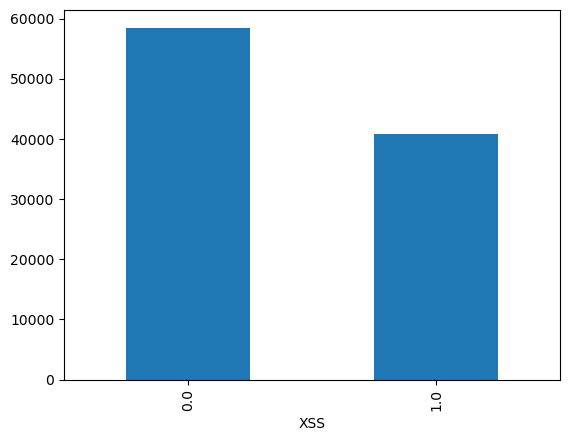

In [4]:
data['XSS'].value_counts().plot(kind='bar')

In [5]:
X_data = data['Sentence']
y_data = data['XSS']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [6]:
print('--------훈 련 데 이 터 의 비 율 -----------')
print(f'정상 쿼리 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'공격 쿼리 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print('--------테 스 트 데 이 터 의 비 율 -----------')
print(f'정상 쿼리 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'공격 쿼리 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------훈 련 데 이 터 의 비 율 -----------
정상 쿼리 = 58.922%
공격 쿼리 = 41.078%
--------테 스 트 데 이 터 의 비 율 -----------
정상 쿼리 = 58.921%
공격 쿼리 = 41.079%


In [7]:
from nltk.tokenize import WordPunctTokenizer
from collections import Counter

tokenizer = WordPunctTokenizer()
X_train_tokens = [tokenizer.tokenize(sentence) for sentence in X_train]
all_tokens = [token.lower() for tokens_in_sentence in X_train_tokens for token in tokens_in_sentence]
word_counts = Counter(all_tokens)
word_to_index = {word: idx + 1 for idx, (word, _) in enumerate(word_counts.most_common())}
X_train_encoded = [[word_to_index[token.lower()] for token in tokens] for tokens in X_train_tokens]

In [8]:
vocab_size = len(word_to_index) + 1
print('단 어 집 합 의 크 기: {}'.format((vocab_size)))

단 어 집 합 의 크 기: 107035


In [28]:
import pickle
with open('xss_index.pkl','wb') as f:
    pickle.dump(word_to_index,f)

쿼리의  최대 길이 : 2588
쿼리의  평균 길이 : 67.994966


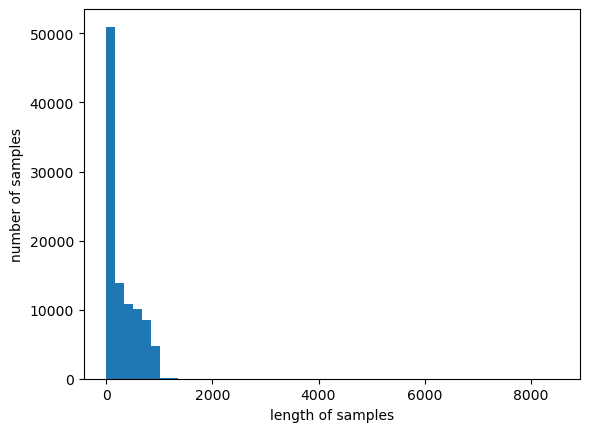

In [9]:
print('쿼리의  최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('쿼리의  평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [10]:
max_len = 114
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (79456, 114)


In [11]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf

embedding_dim = 32
hidden_units = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
y_train = y_train.astype('int32')
history = model.fit(X_train_padded, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
994/994 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - acc: 0.9684 - loss: 0.1016 - val_acc: 0.9989 - val_loss: 0.0055
Epoch 2/4
994/994 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - acc: 0.9987 - loss: 0.0053 - val_acc: 0.9991 - val_loss: 0.0042
Epoch 3/4
994/994 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - acc: 0.9995 - loss: 0.0030 - val_acc: 0.9992 - val_loss: 0.0034
Epoch 4/4
994/994 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - acc: 0.9995 - loss: 0.0028 - val_acc: 0.9992 - val_loss: 0.0027


In [12]:
X_test_tokens = [tokenizer.tokenize(sentence.lower()) for sentence in X_test]
X_test_encoded = [[word_to_index.get(token, 0) for token in tokens] for tokens in X_test_tokens]
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)

y_test = y_test.astype('int32')
print("\n 테 스 트 정 확 도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.9991 - loss: 0.0045

 테 스 트 정 확 도: 0.9992


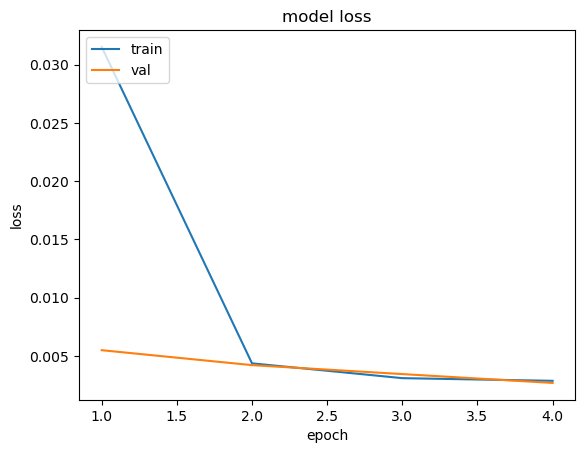

In [13]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
keras.saving.save_model(model, 'xss_model.keras')

In [23]:
model = load_model('xss_model.keras')

In [33]:
def sentiment_predict(new_sentence):
    encoded = [[word_to_index.get(token, 0) for token in tokenizer.tokenize(new_sentence.lower())]]
    padded = pad_sequences(encoded, maxlen=max_len)
    score = float(model.predict(padded))
    
    if score > 0.5:
        print("{:.2f}% 확률로 XSS 공격입니다.".format(score * 100))
        model.fit(padded, pd.Series([1]), epochs=1, verbose=0)
    else:
        print("{:.2f}% 확률로 일반 문장입니다.".format((1 - score) * 100))

sentiment_predict("0cwMHIOrGPcyqzGTMT2O aGM1find / -maxdepth 1 -xdev -type f  -exec grep -li stringtofind '{}' \;icvB1nZ")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
89.43% 확률로 XSS 공격입니다.
